ДЗ 1 Классификация Домашнее задание из двух частей. (после НГ)
База про спортсменов

Креативная часть: найти парамеры и комбинации их, которые будут увеличивать accuracy

Техническая часть: сделать под это всё удобные обёртки. Например, это функция, которая просто принимает список фичей, а на выходе показывает результат фита

### Подключаем библиотеки

In [2]:
import pandas as pd
import seaborn as sns
from sklearn import datasets, linear_model, model_selection
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

In [535]:
import warnings

warnings.filterwarnings('ignore')

### Загружаем исходные данные

In [551]:
file_path = 'athletes_sochi.txt'
df = pd.read_csv(file_path)
df.head()

,age,birthdate,gender,height,name,weight,gold_medals,silver_medals,bronze_medals,total_medals,sport,country
0,17,1996-04-12,Male,1.72,Aaron Blunck,68.0,0,0,0,0,Freestyle Skiing,United States
1,27,1986-05-14,Male,1.85,Aaron March,85.0,0,0,0,0,Snowboard,Italy
2,21,1992-06-30,Male,1.78,Abzal Azhgaliyev,68.0,0,0,0,0,Short Track,Kazakhstan
3,21,1992-05-25,Male,1.68,Abzal Rakimgaliev,NaN,0,0,0,0,Figure Skating,Kazakhstan
4,21,1992-07-30,Male,1.86,Adam Barwood,82.0,0,0,0,0,Alpine Skiing,New Zealand


In [552]:
df.shape

(2859, 12)

### Чистим данные от NaN

In [553]:
df = df.dropna()
df.shape

(2479, 12)

### Попробуем насчитать всяких индексов, связанных с ростом, весом и возрастом
Сделаем фокус на физиолгоических параметрах, учесть медали/страны/имена будет проблематично и пока что непонятно, выборка мала


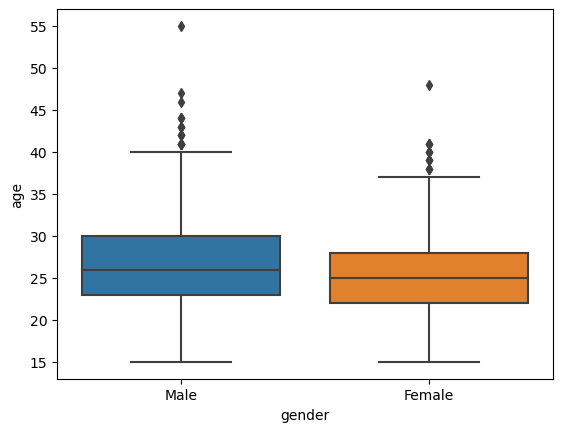

In [554]:
bplot = sns.boxplot(data=df, x="gender", y="age",orient='v')

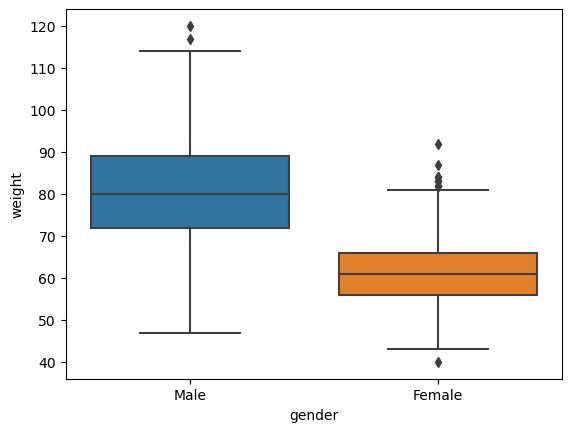

In [555]:
bplot = sns.boxplot(data=df, x="gender", y="weight",orient='v')

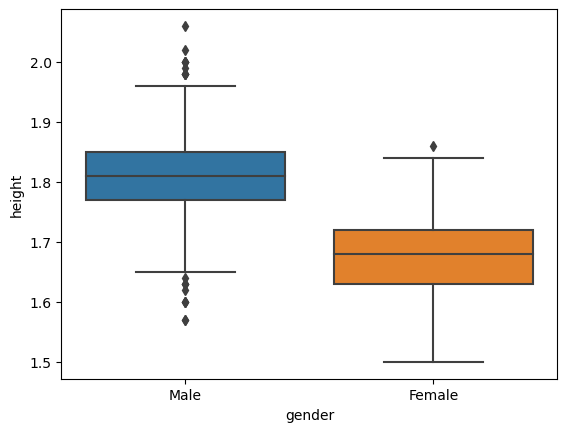

In [556]:
bplot = sns.boxplot(data=df, x="gender", y="height",orient='v')

#### Классический BMI
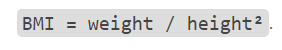

In [557]:
df['BMI'] = df['weight'] / df['height']**2

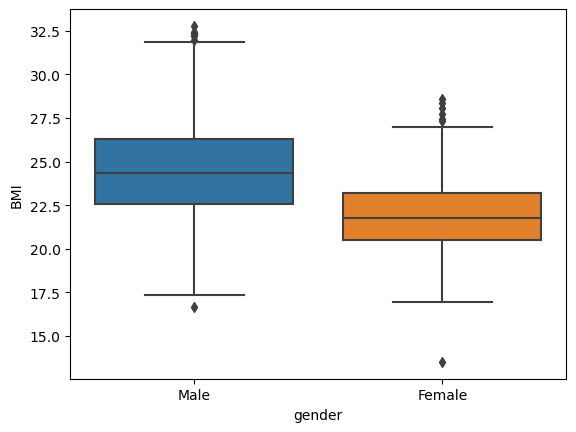

In [558]:
bplot = sns.boxplot(data=df, x="gender", y="BMI",orient='v')

#### Новый  BMI
https://people.maths.ox.ac.uk/trefethen/bmi.html


In [559]:
df['NBMI'] = 1.3 * df['weight'] / df['height']**2.5

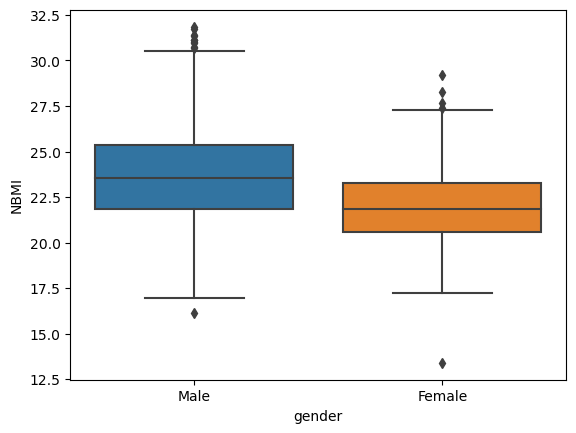

In [560]:
bplot = sns.boxplot(data=df, x="gender", y="NBMI",orient='v')

#### BSA (Body Surface Area)
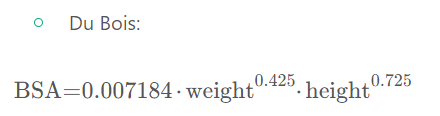

In [561]:
df['BSA'] = 0.007184 *  df['weight']**(0.425) * df['height']**(0.725)

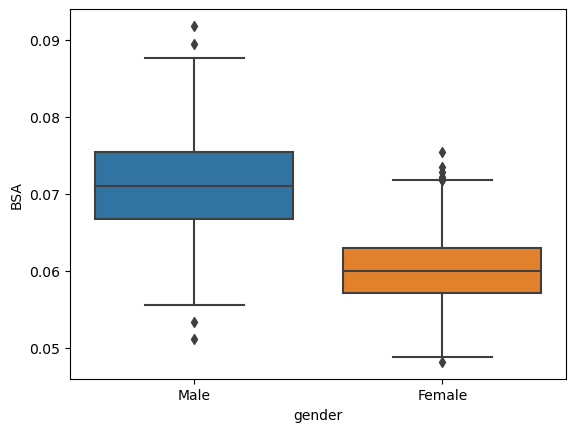

In [562]:
bplot = sns.boxplot(data=df, x="gender", y="BSA",orient='v')

#### Оставим следующие колонки для дальнейшей работы:
- weight
- height
- BMI
- NBMI
- BSA  
По age напрямую сложно будет делать классификацию, судя по распределению.

In [563]:
df = df[['gender', 'height', 'weight', 'BMI', 'NBMI', 'BSA']]
df.head()

,gender,height,weight,BMI,NBMI,BSA
0,Male,1.72,68.0,22.985398,22.784062,0.063965
1,Male,1.85,85.0,24.835646,23.737390,0.074143
2,Male,1.78,68.0,21.461937,20.912322,0.065575
4,Male,1.86,82.0,23.702162,22.593049,0.073305
5,Male,1.75,57.0,18.612245,18.290395,0.060092


#### Посмотрим на соотношение мужчин и женщин

In [564]:
df[df['gender']=='Female'].count()[0]

966

In [565]:
df[df['gender']=='Male'].count()[0]

1513

Небольшой дизбаланс есть, но не критичный, по идее

#### Теперь займёмся функцией, которая принимает на вход наш датафрейм и список фичей, а возвращает результат фита
Метод будет использоваться, что и на лекции - Логистическая регрессия

In [566]:
def lets_go(dataframe, feature_list):
    temp = dataframe.copy()

    exist_features = temp.columns.tolist()
    
    to_use_feature_list = list(set(exist_features).intersection(set(feature_list)))
    
    if 'gender' in to_use_feature_list:
        to_use_feature_list.remove('gender')
    
    
    if len(to_use_feature_list) >0:
        allinput = temp[to_use_feature_list]
        alloutput = temp['gender'].apply(lambda x: int(x == "Male"))
        
        
        X_train, X_test, Y_train, Y_test = model_selection.train_test_split(allinput, alloutput, test_size=0.2)
        
        model = linear_model.LogisticRegression()
        
        model.fit(X_train, Y_train)
        
        Y_test_predicted = model.predict(X_test)
        
        report = classification_report(Y_test, model.predict(X_test), target_names=['Male', 'Female'], output_dict = True)
        
        return report
    else:
        return 'No features in dataframe'

In [567]:
feature_list = df.columns.tolist()
result = lets_go(df, feature_list)
print( result['accuracy'] )


0.8508064516129032


In [568]:
from itertools import combinations

In [569]:
%%time
feature_list = df.columns.tolist()

accuracy = {}

number_of_iterations = 100

for x in range(1,len(feature_list)+1):
    combination = combinations(feature_list, x)
    for i in list(combination):
        for_combination_mean_result = []
        for iteration in range(number_of_iterations):
            result = lets_go(df, list(i))
            try:
                for_combination_mean_result.append(result['accuracy'])
            except:
                for_combination_mean_result.append(-1)

        accuracy[i] = sum(for_combination_mean_result) / len(for_combination_mean_result)
        print(i, accuracy[i])


('gender',) -1.0
('height',) 0.8534072580645164
('weight',) 0.8403629032258064
('BMI',) 0.7194354838709675
('NBMI',) 0.6524395161290322
('BSA',) 0.6099193548387097
('gender', 'height') 0.8524798387096773
('gender', 'weight') 0.8443548387096772
('gender', 'BMI') 0.7190927419354837
('gender', 'NBMI') 0.6538709677419352
('gender', 'BSA') 0.612883064516129
('height', 'weight') 0.8544758064516127
('height', 'BMI') 0.8557661290322581
('height', 'NBMI') 0.8560282258064518
('height', 'BSA') 0.8518346774193549
('weight', 'BMI') 0.8654838709677418
('weight', 'NBMI') 0.8670362903225808
('weight', 'BSA') 0.8417540322580649
('BMI', 'NBMI') 0.8666935483870966
('BMI', 'BSA') 0.7245161290322577
('NBMI', 'BSA') 0.6592943548387098
('gender', 'height', 'weight') 0.8545161290322578
('gender', 'height', 'BMI') 0.858064516129032
('gender', 'height', 'NBMI') 0.856491935483871
('gender', 'height', 'BSA') 0.851995967741935
('gender', 'weight', 'BMI') 0.866673387096774
('gender', 'weight', 'NBMI') 0.86518145161

In [570]:
print(max(accuracy, key=accuracy.get))

print(accuracy[max(accuracy, key=accuracy.get)])

('height', 'weight', 'BMI', 'BSA')
0.8678427419354838


In [571]:
from_lection = ['height', 'weight', 'BMI']
from_lection = tuple(from_lection)
print(from_lection, accuracy[from_lection])

('height', 'weight', 'BMI') 0.8635080645161292


Accuracy из лекции


### Вывод
В ходе работы accuracy существенно не изменился, несмотря на то, что стало больше фичей, чем в лекции. 